In [8]:
%run ../paths.py
print("RAW_DATA_DIR:", RAW_DATA_DIR)

RAW_DATA_DIR: /Users/ricardoheredia/Desktop/retail-forecasting/data/raw


In [2]:
import os
import numpy as np
import pandas as pd
import sqlalchemy as sa
from sqlalchemy import inspect

In [9]:
db_filename = 'supermarket.db'  # Change as needed
database_path = RAW_DATA_DIR / db_filename

In [10]:
print("Database path:", database_path)

Database path: /Users/ricardoheredia/Desktop/retail-forecasting/data/raw/supermarket.db


In [12]:
con = sa.create_engine('sqlite:///' + str(database_path))

In [13]:
insp = inspect(con)
tables = insp.get_table_names()
tables

['calendar', 'sales', 'sell_prices']

In [14]:
cal = pd.read_sql('calendar', con)
cal.drop(columns='index',inplace=True)
cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2
0,2013-01-01,11249,Tuesday,4,1,2013,d_704,NewYear,National,None,None
1,2013-01-02,11249,Wednesday,5,1,2013,d_705,None,None,None,None
2,2013-01-03,11249,Thursday,6,1,2013,d_706,None,None,None,None
3,2013-01-04,11249,Friday,7,1,2013,d_707,None,None,None,None
4,2013-01-05,11250,Saturday,1,1,2013,d_708,None,None,None,None


In [15]:
sales = pd.read_sql('sales', con)
sales.drop(columns='index',inplace=True)
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_704,d_705,d_706,d_707,...,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798
0,FOODS_3_090_CA_3_validation,FOODS_3_090,FOODS_3,FOODS,CA_3,CA,0,224,241,232,...,5,2,0,0,6,0,6,0,0,0
1,FOODS_3_120_CA_3_validation,FOODS_3_120,FOODS_3,FOODS,CA_3,CA,0,0,0,0,...,54,63,44,0,65,90,104,73,76,97
2,FOODS_3_202_CA_3_validation,FOODS_3_202,FOODS_3,FOODS,CA_3,CA,20,23,23,25,...,43,40,39,0,29,33,27,13,26,47
3,FOODS_3_252_CA_3_validation,FOODS_3_252,FOODS_3,FOODS,CA_3,CA,34,27,40,49,...,31,43,32,0,52,37,32,29,34,27
4,FOODS_3_288_CA_3_validation,FOODS_3_288,FOODS_3,FOODS,CA_3,CA,0,0,0,0,...,29,45,28,0,46,36,40,31,46,36


In [16]:
prices = pd.read_sql('sell_prices', con)
prices.drop(columns='index',inplace=True)
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_3,FOODS_3_090,11249,1.25
1,CA_3,FOODS_3_090,11250,1.25
2,CA_3,FOODS_3_090,11251,1.25
3,CA_3,FOODS_3_090,11252,1.25
4,CA_3,FOODS_3_090,11301,1.38


- Calendar Table:

Contains date-related information
Has columns for date, wm_yr_wk (Walmart year week), weekday, month, year
Important column 'd' (like d_704) which is used as a reference in the sales table
Contains event information (event_name_1, event_type_1, etc.)

- Sales Table:

Contains sales data for different items across stores
Has item_id, store_id, department (dept_id), category (cat_id), and state information
The columns d_704 through d_1798 represent daily sales quantities
These 'd_' columns correspond to the 'd' column in the calendar table
Prices Table (sell_prices):
Contains pricing information for items
Has store_id, item_id, wm_yr_wk, and sell_price
Shows the price of items by week at different stores
The relationships (as shown in the diagram):

- Calendar and Sales tables have a many-to-many relationship (∞)
- Sales and Prices tables are connected through [wm_yr_wk, store_id, item_id] as key fields

This I you can:
- Link sales data to specific dates using the 'd' columns
- Find the price of any item at any store during a specific week
- Analyze sales patterns along with pricing and calendar events

For example, if you want to analyze the sales of FOODS_3_090 at store CA_3:

Use the calendar table to get the dates
Look up the sales quantities from the sales table
Match the pricing from the prices table using wm_yr_wk, store_id, and item_id

#### Modular code

In [1]:
# First cell - Imports and setup
%run ../paths.py  # Run your paths file

import pandas as pd
from typing import Dict, List
import sqlalchemy as sa
from sqlalchemy import inspect
import logging
from datetime import datetime
import numpy as np
from dataclasses import dataclass

In [4]:
# Second cell - Config class
@dataclass
class Config:
    """Application configuration"""
    RAW_DATA_DIR: Path = RAW_DATA_DIR
    TRANSFORMED_DATA_DIR: Path = TRANSFORMED_DATA_DIR
    DATA_CACHE_DIR: Path = DATA_CACHE_DIR
    DATABASE_NAME: str = 'supermarket.db'
    LOG_LEVEL: str = 'INFO'
    LOG_FORMAT: str = '%(asctime)s - %(levelname)s - %(message)s'

    # Database configuration
    DB_TYPE: str = 'sqlite'

    # Validation thresholds
    MIN_PRICE: float = 0.0
    MAX_PRICE: float = 1000.0

    @property
    def database_path(self) -> Path:
        return self.RAW_DATA_DIR / self.DATABASE_NAME

In [5]:
# Third cell - Logging setup
def setup_logging(config: Config):
    """Configure logging settings"""
    log_filename = f"data_transformation_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"

    logging.basicConfig(
        level=config.LOG_LEVEL,
        format=config.LOG_FORMAT,
        handlers=[
            logging.FileHandler(log_filename),
            logging.StreamHandler()
        ]
    )

In [9]:
# Fourth cell - Validation classes
@dataclass
class DataValidationRules:
    """Data validation rules for each table"""
    required_columns: Dict[str, List[str]]
    data_types: Dict[str, Dict[str, type]]
    value_ranges: Dict[str, Dict[str, tuple]]

    @classmethod
    def get_default_rules(cls, config: Config):
        """Define default validation rules"""
        return cls(
            required_columns={
                'calendar': ['date', 'wm_yr_wk', 'd'],
                'sales': ['id', 'item_id', 'store_id'],
                'prices': ['store_id', 'item_id', 'wm_yr_wk', 'sell_price']  # This key stays as 'prices' for internal reference
            },
            data_types={
                'prices': {'sell_price': float},
                'sales': {'store_id': str, 'item_id': str}
            },
            value_ranges={
                'prices': {'sell_price': (config.MIN_PRICE, config.MAX_PRICE)}
            }
        )

class DataValidator:
    """Class to validate data quality"""

    def __init__(self, rules: DataValidationRules):
        self.rules = rules

    def validate_dataframe(self, df: pd.DataFrame, table_name: str) -> bool:
        """Validate a dataframe against defined rules"""
        logging.info(f"Validating {table_name} dataset...")

        # Check required columns
        if table_name in self.rules.required_columns:
            missing_cols = set(self.rules.required_columns[table_name]) - set(df.columns)
            if missing_cols:
                logging.error(f"Missing required columns in {table_name}: {missing_cols}")
                return False

        # Check data types
        if table_name in self.rules.data_types:
            for col, expected_type in self.rules.data_types[table_name].items():
                if col in df.columns:
                    try:
                        df[col] = df[col].astype(expected_type)
                    except Exception as e:
                        logging.error(f"Data type validation failed for {col} in {table_name}: {str(e)}")
                        return False

        # Check value ranges
        if table_name in self.rules.value_ranges:
            for col, (min_val, max_val) in self.rules.value_ranges[table_name].items():
                if col in df.columns:
                    invalid_values = df[~df[col].between(min_val, max_val)]
                    if not invalid_values.empty:
                        logging.error(f"Invalid values found in {col} of {table_name}")
                        return False

        logging.info(f"Validation successful for {table_name}")
        return True

In [27]:
class DataTransformer:
    """Class to handle data transformations and preprocessing for sales analysis"""

    def __init__(self, config: Config, validator: DataValidator):
        """Initialize with config and validator"""
        self.config = config
        self.engine = sa.create_engine(f'{config.DB_TYPE}:///{str(config.database_path)}')
        self.validator = validator
        self.preprocessor = DataPreprocessor()
        logging.info("DataTransformer initialized")

    def load_tables(self) -> Dict[str, pd.DataFrame]:
        """Load all tables from database"""
        tables = {}
        try:
            # Updated table names to match database
            table_mapping = {
                'calendar': 'calendar',
                'sales': 'sales',
                'prices': 'sell_prices'  # Changed from 'prices' to 'sell_prices'
            }

            for table_key, table_name in table_mapping.items():
                logging.info(f"Loading {table_name} table...")
                df = pd.read_sql_table(table_name, self.engine)

                if 'index' in df.columns:
                    df.drop(columns='index', inplace=True)

                if not self.validator.validate_dataframe(df, table_key):
                    raise ValueError(f"Data validation failed for {table_name}")

                tables[table_key] = df
                logging.info(f"Successfully loaded {table_name} table")

        except Exception as e:
            logging.error(f"Error loading tables: {str(e)}")
            raise

        return tables

    def transform_sales_to_long(self, sales_df: pd.DataFrame) -> pd.DataFrame:
        """Transform sales data from wide to long format"""
        logging.info("Starting sales transformation to long format...")

        try:
            id_columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
            sales_columns = [col for col in sales_df.columns if col.startswith('d_')]

            sales_long = pd.melt(
                sales_df,
                id_vars=id_columns,
                value_vars=sales_columns,
                var_name='d',
                value_name='sales'
            )

            logging.info(f"Successfully transformed sales data. Shape: {sales_long.shape}")
            return sales_long

        except Exception as e:
            logging.error(f"Error transforming sales data: {str(e)}")
            raise

    def merge_calendar_sales(self, calendar_df: pd.DataFrame, sales_long_df: pd.DataFrame) -> pd.DataFrame:
        """Merge calendar and sales data"""
        logging.info("Merging calendar and sales data...")
        try:
            merged_df = pd.merge(
                sales_long_df,
                calendar_df,
                on='d',
                how='left'
            )
            logging.info(f"Successfully merged calendar and sales. Shape: {merged_df.shape}")
            return merged_df
        except Exception as e:
            logging.error(f"Error merging calendar and sales: {str(e)}")
            raise

    def merge_with_prices(self, merged_df: pd.DataFrame, prices_df: pd.DataFrame) -> pd.DataFrame:
        """Merge with prices data and apply preprocessing"""
        logging.info("Merging with prices data...")
        try:
            final_df = pd.merge(
                merged_df,
                prices_df,
                on=['store_id', 'item_id', 'wm_yr_wk'],
                how='left'
            )
            logging.info(f"Successfully merged with prices. Shape: {final_df.shape}")

            # Apply preprocessing after merging
            logging.info("Starting preprocessing steps...")
            final_df = self.preprocessor.preprocess(final_df)
            logging.info("Preprocessing completed successfully")

            return final_df
        except Exception as e:
            logging.error(f"Error in merge_with_prices or preprocessing: {str(e)}")
            raise

In [28]:
class DataPreprocessor:
    """Handles data preprocessing for the retail forecasting project"""
    def __init__(self):
        self.column_order = ['date',
                            'state_id',
                            'store_id',
                            'dept_id',
                            'cat_id',
                            'item_id',
                            'wm_yr_wk',
                            'd',
                            'ventas',
                            'sell_price',
                            'year',
                            'month',
                            'wday',
                            'weekday',
                            'event_name_1',
                            'event_type_1',
                            'event_name_2',
                            'event_type_2']

        self.categorical_columns = ['year', 'month', 'wday']
        self.columns_to_drop = ['state_id', 'cat_id', 'dept_id']
        self.event_columns_to_drop = ['event_name_2', 'event_type_2']

    def handle_data_types(self, df: pd.DataFrame) -> pd.DataFrame:
        """Convert columns to appropriate data types"""
        logging.info("Converting columns to appropriate data types...")
        df_copy = df.copy()

        # Convert to categorical
        for col in self.categorical_columns:
            if col in df_copy.columns:
                df_copy[col] = df_copy[col].astype('category')

        return df_copy

    def handle_missing_values(self, df: pd.DataFrame) -> pd.DataFrame:
        """Handle missing values in the dataset"""
        logging.info("Handling missing values...")
        df_copy = df.copy()

        # Handle event-related missing values
        event_cols = ['event_name_1', 'event_type_1']
        df_copy[event_cols] = df_copy[event_cols].fillna('no_event')

        # Handle missing sell_price values
        if 'sell_price' in df_copy.columns:
            df_copy = self._impute_missing_prices(df_copy)

        return df_copy

    def _impute_missing_prices(self, df: pd.DataFrame) -> pd.DataFrame:
        """Impute missing prices with mode by item_id"""
        def impute_mode(group):
            mode_price = group['sell_price'].mode()[0]
            group.loc[group['sell_price'].isna(), 'sell_price'] = mode_price
            return group

        return df.groupby('item_id', group_keys=False).apply(impute_mode)

    def drop_unnecessary_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        """Remove unnecessary columns"""
        logging.info("Removing unnecessary columns...")
        columns_to_drop = self.columns_to_drop + self.event_columns_to_drop
        return df.drop(columns=[col for col in columns_to_drop if col in df.columns])

    def reorder_and_set_index(self, df: pd.DataFrame) -> pd.DataFrame:
        """Reorder columns and set date as index"""
        logging.info("Reordering columns and setting index...")
        # Keep only columns that exist in the dataframe
        valid_columns = [col for col in self.column_order if col in df.columns]
        return df[valid_columns].set_index('date')

    def preprocess(self, df: pd.DataFrame) -> pd.DataFrame:
        """Main preprocessing pipeline"""
        logging.info("Starting preprocessing pipeline...")

        df = self.handle_data_types(df)
        df = self.handle_missing_values(df)
        df = self.drop_unnecessary_columns(df)
        df = self.reorder_and_set_index(df)

        logging.info("Preprocessing completed successfully")
        return df

In [29]:
# Sixth cell - Main execution
def main():
    """Main execution function"""
    config = Config()
    setup_logging(config)

    validator = DataValidator(DataValidationRules.get_default_rules(config))
    transformer = DataTransformer(config, validator)

    try:
        logging.info("Starting data transformation process...")

        # Load and validate raw tables
        logging.info("Loading and validating raw tables...")
        tables = transformer.load_tables()

        # Transform sales data to long format
        logging.info("Transforming sales data to long format...")
        sales_long = transformer.transform_sales_to_long(tables['sales'])
        logging.info(f"Sales long format shape: {sales_long.shape}")

        # Merge calendar with sales
        logging.info("Merging calendar with sales data...")
        merged_cal_sales = transformer.merge_calendar_sales(tables['calendar'], sales_long)
        logging.info(f"Merged calendar-sales shape: {merged_cal_sales.shape}")

        # Merge prices and apply preprocessing
        logging.info("Merging prices and applying preprocessing...")
        final_df = transformer.merge_with_prices(merged_cal_sales, tables['prices'])
        logging.info(f"Final DataFrame shape: {final_df.shape}")

        # Data quality checks after preprocessing
        logging.info("Performing final data quality checks...")
        logging.info(f"Columns in final DataFrame: {final_df.columns.tolist()}")
        logging.info(f"Missing values:\n{final_df.isnull().sum()}")

        # Save the processed DataFrame
        output_path = config.TRANSFORMED_DATA_DIR / 'transformed_sales.parquet'
        final_df.to_parquet(output_path)
        logging.info(f"Data transformation completed successfully! Saved to {output_path}")

        # Print summary statistics
        logging.info("\nFinal Dataset Summary:")
        logging.info(f"Date Range: {final_df.index.min()} to {final_df.index.max()}")
        logging.info(f"Number of stores: {final_df['store_id'].nunique()}")
        logging.info(f"Number of items: {final_df['item_id'].nunique()}")
        logging.info(f"Total number of records: {len(final_df)}")

        return final_df

    except Exception as e:
        logging.error(f"Fatal error in main execution: {str(e)}")
        logging.error(f"Error details: {str(e.__class__.__name__)}: {str(e)}")
        raise

In [30]:
# Seventh cell - Run the transformation
if __name__ == "__main__":
    final_df = main()
else:
    # When running in notebook
    final_df = main()

2025-02-04 22:55:55,010 - INFO - DataTransformer initialized
2025-02-04 22:55:55,024 - INFO - Starting data transformation process...
2025-02-04 22:55:55,028 - INFO - Loading and validating raw tables...
2025-02-04 22:55:55,034 - INFO - Loading calendar table...
2025-02-04 22:55:55,578 - INFO - Validating calendar dataset...
2025-02-04 22:55:55,581 - INFO - Validation successful for calendar
2025-02-04 22:55:55,585 - INFO - Successfully loaded calendar table
2025-02-04 22:55:55,587 - INFO - Loading sales table...
2025-02-04 22:55:56,282 - INFO - Validating sales dataset...
2025-02-04 22:55:56,289 - INFO - Validation successful for sales
2025-02-04 22:55:56,291 - INFO - Successfully loaded sales table
2025-02-04 22:55:56,292 - INFO - Loading sell_prices table...
2025-02-04 22:55:56,327 - INFO - Validating prices dataset...
2025-02-04 22:55:56,353 - INFO - Validation successful for prices
2025-02-04 22:55:56,355 - INFO - Successfully loaded sell_prices table
2025-02-04 22:55:56,356 - INF

### Visualize the parquet data

In [31]:
# Direct path to the file
file_path = '/Users/ricardoheredia/Desktop/retail-forecasting/data/transformed/transformed_sales.parquet'

# Read the parquet file
df = pd.read_parquet(file_path)

# Quick peek at the data
df.head()

,store_id,item_id,wm_yr_wk,d,sell_price,year,month,wday,weekday,event_name_1,event_type_1
date,,,,,,,,,,,
2013-01-01,CA_3,FOODS_3_090,11249,d_704,1.25,2013,1,4,Tuesday,NewYear,National
2013-01-01,CA_3,FOODS_3_120,11249,d_704,4.98,2013,1,4,Tuesday,NewYear,National
2013-01-01,CA_3,FOODS_3_202,11249,d_704,4.28,2013,1,4,Tuesday,NewYear,National
2013-01-01,CA_3,FOODS_3_252,11249,d_704,1.48,2013,1,4,Tuesday,NewYear,National
2013-01-01,CA_3,FOODS_3_288,11249,d_704,1.50,2013,1,4,Tuesday,NewYear,National


In [26]:
df[['store_id','item_id','wm_yr_wk','d','sell_price']]\
    .sort_values(by = ['store_id','item_id','wm_yr_wk','d'])\
    .head(10)

,store_id,item_id,wm_yr_wk,d,sell_price
0,CA_3,FOODS_3_090,11249,d_704,1.25
20,CA_3,FOODS_3_090,11249,d_705,1.25
40,CA_3,FOODS_3_090,11249,d_706,1.25
60,CA_3,FOODS_3_090,11249,d_707,1.25
80,CA_3,FOODS_3_090,11250,d_708,1.25
100,CA_3,FOODS_3_090,11250,d_709,1.25
120,CA_3,FOODS_3_090,11250,d_710,1.25
140,CA_3,FOODS_3_090,11250,d_711,1.25
160,CA_3,FOODS_3_090,11250,d_712,1.25
180,CA_3,FOODS_3_090,11250,d_713,1.25


In [16]:
# Basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
display(df.head())

Dataset Shape: (21900, 19)

Columns: ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'sales', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'sell_price']

First few rows:


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,sell_price
0,FOODS_3_090_CA_3_validation,FOODS_3_090,FOODS_3,FOODS,CA_3,CA,d_704,0,2013-01-01,11249,Tuesday,4,1,2013,NewYear,National,None,None,1.25
1,FOODS_3_120_CA_3_validation,FOODS_3_120,FOODS_3,FOODS,CA_3,CA,d_704,0,2013-01-01,11249,Tuesday,4,1,2013,NewYear,National,None,None,4.98
2,FOODS_3_202_CA_3_validation,FOODS_3_202,FOODS_3,FOODS,CA_3,CA,d_704,20,2013-01-01,11249,Tuesday,4,1,2013,NewYear,National,None,None,4.28
3,FOODS_3_252_CA_3_validation,FOODS_3_252,FOODS_3,FOODS,CA_3,CA,d_704,34,2013-01-01,11249,Tuesday,4,1,2013,NewYear,National,None,None,1.48
4,FOODS_3_288_CA_3_validation,FOODS_3_288,FOODS_3,FOODS,CA_3,CA,d_704,0,2013-01-01,11249,Tuesday,4,1,2013,NewYear,National,None,None,NaN


In [18]:
# Method 2: More detailed exploration
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21900 entries, 0 to 21899
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            21900 non-null  object 
 1   item_id       21900 non-null  object 
 2   dept_id       21900 non-null  object 
 3   cat_id        21900 non-null  object 
 4   store_id      21900 non-null  object 
 5   state_id      21900 non-null  object 
 6   d             21900 non-null  object 
 7   sales         21900 non-null  int64  
 8   date          21900 non-null  object 
 9   wm_yr_wk      21900 non-null  int64  
 10  weekday       21900 non-null  object 
 11  wday          21900 non-null  int64  
 12  month         21900 non-null  int64  
 13  year          21900 non-null  int64  
 14  event_name_1  1740 non-null   object 
 15  event_type_1  1740 non-null   object 
 16  event_name_2  60 non-null     object 
 17  event_type_2  60 non-null     object 
 18  sell_price 

In [19]:

print("\nMemory usage:")
print(df.memory_usage(deep=True).sum() / 1024**2, "MB")


Memory usage:
13.985225677490234 MB


In [21]:
# Method 3: Basic statistics
print("\nBasic statistics:")
display(df.describe())


Basic statistics:


,sales,wm_yr_wk,wday,month,year,sell_price
count,21900.000000,21900.000000,21900.000000,21900.000000,21900.000000,21829.000000
mean,28.675890,11418.734247,4.002740,6.526027,2014.000000,2.398431
std,38.655043,84.538117,1.998445,3.447930,0.816515,1.238448
min,0.000000,11249.000000,1.000000,1.000000,2013.000000,1.000000
25%,6.000000,11336.000000,2.000000,4.000000,2013.000000,1.500000
50%,18.000000,11422.000000,4.000000,7.000000,2014.000000,1.580000
75%,37.000000,11509.000000,6.000000,10.000000,2015.000000,2.980000
max,763.000000,11548.000000,7.000000,12.000000,2015.000000,4.980000


In [22]:
# Method 4: Check for missing values
print("\nMissing values:")
display(df.isnull().sum())


Missing values:


id                  0
item_id             0
dept_id             0
cat_id              0
store_id            0
state_id            0
d                   0
sales               0
date                0
wm_yr_wk            0
weekday             0
wday                0
month               0
year                0
event_name_1    20160
event_type_1    20160
event_name_2    21840
event_type_2    21840
sell_price         71
dtype: int64

In [24]:
# Method 5: If you want to see unique values in specific columns
columns_of_interest = ['store_id', 'item_id', 'dept_id', 'cat_id']
for col in columns_of_interest:
    if col in df.columns:
        print(f"\nUnique values in {col}:", df[col].nunique())


Unique values in store_id: 2

Unique values in item_id: 10

Unique values in dept_id: 1

Unique values in cat_id: 1


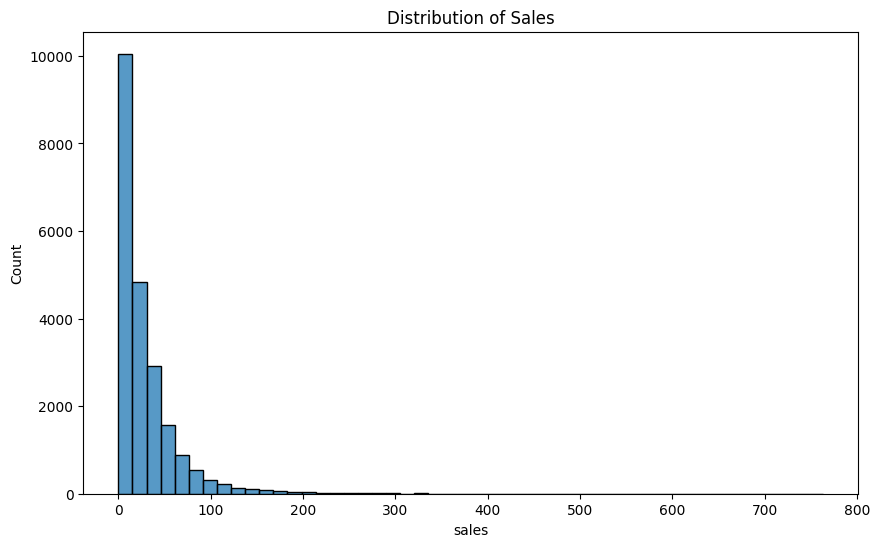

In [25]:
# Method 6: Quick visualization of sales distribution
if 'sales' in df.columns:
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='sales', bins=50)
    plt.title('Distribution of Sales')
    plt.show()